In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shielded_mol_py as sm

DATA_PATH = "../data"

In [2]:
hbar = 1.05457182e-34
epsilon_0 = 8.85418782e-12
d = 2.72 * 3.33564e-30
delta_r = 0.1
M = 1.029e-25
mu = M / 2
omega_trap = 3.5 * 2 * np.pi * 1e5
xi = 0
Omega = 40 * 2 * np.pi * 1e6
lho = np.sqrt(hbar / (mu * omega_trap))
Eho = hbar * omega_trap
C3 = d**2 / (48 * np.pi * epsilon_0 * (1 + delta_r**2)) / (Eho * lho**3)
C6 = d**4 / (128 * np.pi**2 * epsilon_0**2 * hbar * Omega * (1 + delta_r**2)**1.5) / (Eho * lho**6)

print(C3, C6)

9.25010281855974 13.543607688069887


In [4]:
l_max = 2

params = sm.SystemParams(l_max, "all", "none", (0, 0), C6, C3, xi, 1, 1, 0.)
problem = sm.Problem(params, 0.6, 1.5, 6.)
problem.step_rule(1e-3, 1., 500)
problem.node_range(0, 4)

bounds = problem.bound_states((0, 5), 1e-4)
for b in bounds:
    print(b.nodes, b.energy)

0 2.6129857698645242
1 3.0631637573242188
2 3.0631637573242188
3 3.4053421020507812
4 3.4053460229188204


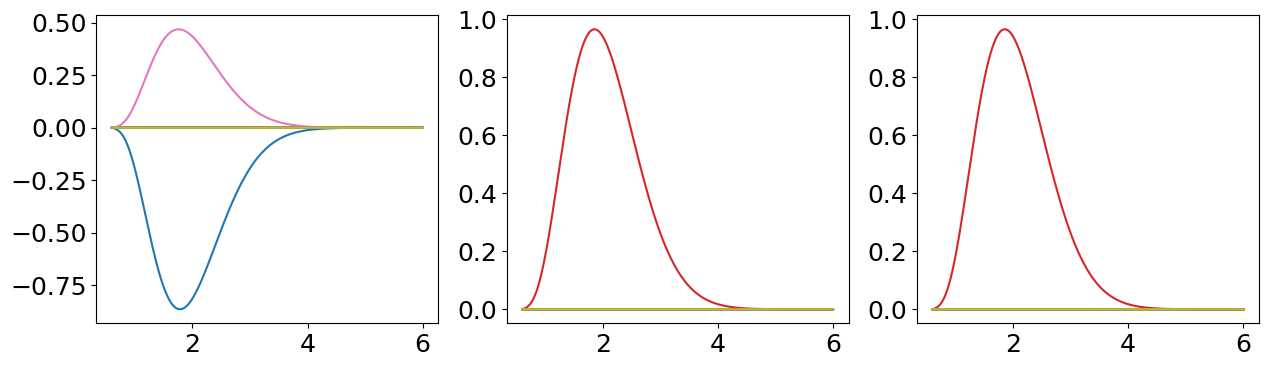

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))

(r, values) = problem.wave_function(bounds[0])
values = np.array(values)
axes[0].plot(r, values)

(r, values) = problem.wave_function(bounds[1])
values = np.array(values)
axes[1].plot(r, values)

(r, values) = problem.wave_function(bounds[2])
values = np.array(values)
axes[2].plot(r, values);

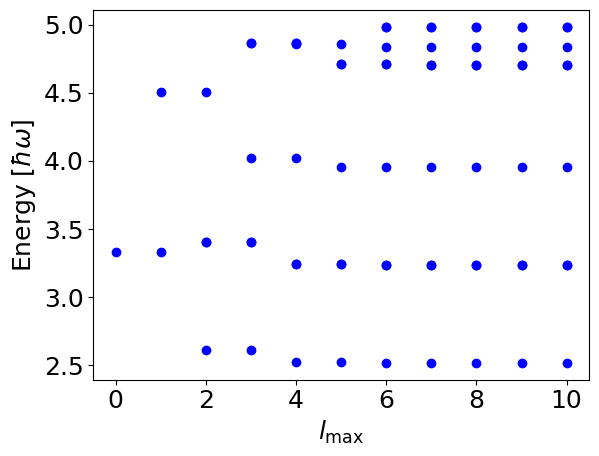

In [6]:
fig, ax = plt.subplots()
ax.set_ylabel(r"Energy [$\hbar \omega$]")
ax.set_xlabel(r"$l_\text{max}$")

for l_max in range(11):
    params = sm.SystemParams(l_max, "even", "none", (0, 0), C6, C3, xi, 1, 1, 0.)
    problem = sm.Problem(params, 0.6, 1.5, 6.)
    problem.step_rule(1e-3, 1., 500)

    bounds = problem.bound_states((0, 5), 1e-4)
    bounds = np.array([[l_max, b.energy] for b in bounds])
    ax.scatter(bounds[:, 0], bounds[:, 1], color = "blue");

In [3]:
k_f = np.cbrt(6 * np.pi**2 * 1e12) * 100

params = sm.SystemParams(11, "odd", "fermionic", (1, 1), C6, C3, xi, 0, 1, 0.04 * k_f * k_f * hbar * hbar / M / Eho)
problem = sm.Problem(params, 0.6, 1.5, 1e3)
problem.step_rule(1e-3, 100., 100)

s_length = problem.scattering(0.6, 100).scattering_length_re

print(s_length)
print(len(problem.channels()))

-1.6064114764963986
42


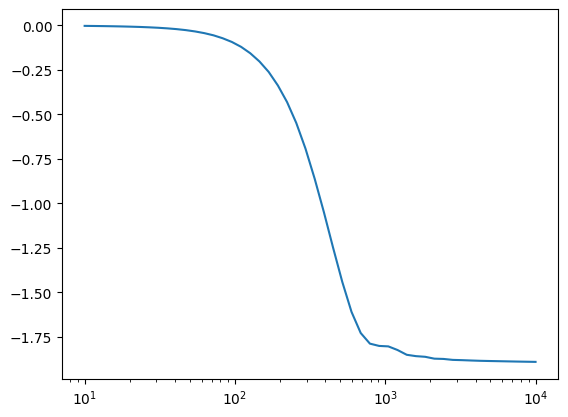

In [26]:
k_f = np.cbrt(6 * np.pi**2 * 1e12) * 100
E_f = k_f * k_f * hbar * hbar / M / Eho

r_maxes = np.logspace(1, 4, 50)
s_lengths = []
for r_max in r_maxes:
    params = sm.SystemParams(7, "odd", "fermionic", (1, 1), C6, C3, xi, 0, 1, 0.04**2 * E_f)
    problem = sm.Problem(params, 0.6, 1.5, 1e4)
    problem.step_rule(1e-1, 1000, 200)

    s_length = problem.scattering(0.6, r_max).scattering_length_re
    s_lengths.append(s_length)


fig, ax = plt.subplots()
ax.plot(r_maxes, s_lengths)
ax.set_xscale("log")

In [29]:
k_f = np.cbrt(6 * np.pi**2 * 1e12) * 100
E_f = k_f * k_f * hbar * hbar / M / Eho

omega_muls = np.linspace(0.5, 10/4, 100)
energies = np.array([0.04, 0.45, 1])**2 * E_f

cross_sects = []
for energy in energies:
    cross_sections = []
    for omega_mul in omega_muls:
        params = sm.SystemParams(7, "odd", "fermionic", (1, 1), C6 / omega_mul, C3, xi, 0, 1, energy)
        problem = sm.Problem(params, 0.6, 1.5, 1e3)
        problem.step_rule(1e-3, 100., 400)

        # change distance vs energy (too far propagation = errors, errors propartional to wavelength)
        cross_sect = problem.scattering(0.6, 5e3 * 0.04 / np.sqrt(energy / E_f)).elastic_cross_sect
        cross_sections.append(cross_sect)
    cross_sects.append(cross_sections)

(0.1, 300.0)

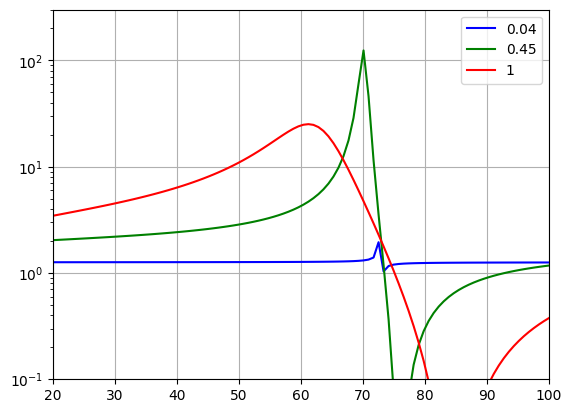

In [30]:
colors = ["blue", "green", "red"]

fig, ax = plt.subplots()
ax.grid()
for energy, cross_sections, color in zip(energies, cross_sects, colors):
    ax.plot(omega_muls * 40, 2 * np.array(cross_sections) * (k_f * lho)**2, color = color)
ax.legend(labels = [0.04, 0.45, 1])
ax.set_yscale("log")
ax.set_xlim(20, 100)
ax.set_ylim(1e-1, 3e2)